# Part 3E: Bootstrapping Confidence Intervals

The confidence intervals calculated with the uncertain fit parameters determined using ```scipy.optimize.curve_fit``` or ```lmfit.fit``` are symmetrical. We get $\pm$ some value as the standard deviation. This is a perfectly good was to estimate the confidence interval (all errors are estimated) but it hides a subtle truth. The confidence is not symmetrical. The data does not necesssarity have the same contribution to each parameter across the range of measuremnts and some regions may have more error than others, especially with non-linear curve fits.

One way to estimate a confidence interval that reflects these regional effects in your data series is to use bootstrapping. It is a computationally expensive method where we randomly select data points from our data set and perfomr the curve fit hundreds, perhaps thousands of times. Then we values for the parameters that encompass the 68%, 95% and 99% percentiles ($1\sigma$, $2\sigma$, $3\sigma$) or any arbitrary range we like. The median values and these upper and lower bounds will reflect a more accurate picture of estimated error, if we have enough data.

This method may not be useful with small data sets as there may not be enough combinations such that percentiles are meaningful. Choosing the 95% percentile range from 6 discrete values is not useful. However, there are ways to magnify the amount of data through applying random error to data points. Is that appropriate? Some say yes, some say no. Regardless, you will know exactly what I did to determine the confidence interval for my experiment because the code is available for your inspection.

## Setup

As before, we load in the *Python* packages needed and set global variables.

In [6]:
### Setup environment

!mkdir plots

### Install and load packages

!pip install uncertainties              # uncomment to install dependancy

from scipy.optimize import curve_fit     # tool for curve fitting
from scipy.stats import linregress     # tool for curve fitting
import scipy                             # includes tools for data analysis
import scipy.stats
import numpy as np                       # import the tools of NumPy but use a shorter name, "np"
from matplotlib import pyplot as plt     # tools for plotting

import uncertainties as un               # tool set for handling numbers with uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy that uses uncertainty values

### Set global variables

#location_data = "data/"         ## Use either local folder or github folder. 
#location_styles = "styles/"     ## Use github locations for Colab
location_data = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/data/"
location_styles = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/styles/"


## The Data Set

We will begin with the 5-point data set that we have been using so far.

In [7]:
temp =     [293, 298,  303,  308,  313]       # list of temperatures
k_obs =    [7.6, 11.7, 15.2, 21.3, 27.8]      # list of observe rate constants (s^-1)
k_obs_err= [0.2, 0.3,  0.1,  0.9,  0.9]       # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)

temp = np.array(temp)              # an array of float values
k = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculate x, y values and the uncertainty y_err using the
###   error propagation provided by the *uncertainties* package

x = 1/temp                         # 1/T
y_u = unp.log(k/temp)              # ln(k/T) uncertain array for y-axis

### Separate the uncertain y value into y and y_err for use in the curve_fit function

y = unp.nominal_values(y_u)        # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)          #   because curve_fit can't handle ufloats

#display(x, k, y_u)

## A Quick Bootstrap

We can get a bootstrapped confidence interval using the ```seaborn.regplot()``` function that is part of the *Seaborn* plotting package. It will perform a bootstrap analysis and plot the confidence interval requested (below I am using a stardard 95% confiodence interval. Change the confidence and see what happens.)

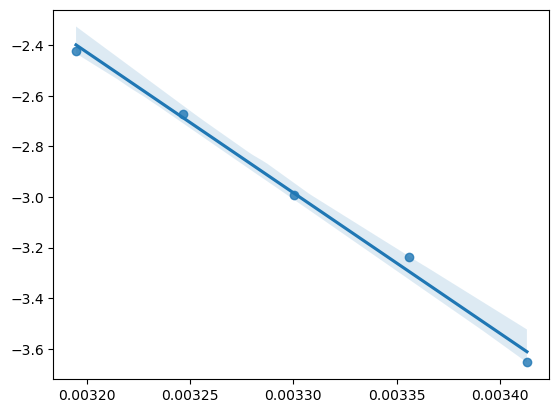

In [8]:
import seaborn as sns
plt.rcdefaults()

sns.regplot(x = x, y = y, ci = 95.7)

plt.show()


### Styling the Plot

Below is the same plot as above but I have added styling to the plot to fit with my own preferred publication style. We can send plotting style parameters into the ```regplot()``` function using keyword dictionaries.

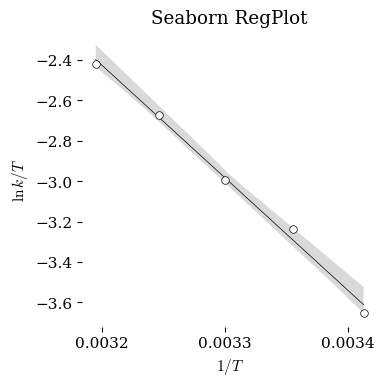

In [9]:
import seaborn as sns
plt.rcdefaults()

style = "tufte.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

sns.regplot(x = x, y = y,
            scatter_kws = {"facecolor": "white", "edgecolor": "black", "s": 30, "linewidths":0.5, "alpha": 1, "zorder":3},
            line_kws = {"color": "black", "linewidth":0.5, "zorder":2}, 
            ci = 95.5, # sigma = 2
            )
plt.xticks([0.0032,0.0033,0.0034])   # Set values to display on x-axis
plt.xlabel(r"${1/T}$")
plt.ylabel(r"$\ln{k/T}$")
plt.title("Seaborn RegPlot")
plt.savefig("plots/seaborn2.pdf")
plt.show()

## The Bootstrap

The code below will sample points from the data with replacement. That means that in a list of 1-2-3-4-5 we might sample 1-3-4-1-2. Note that we might have two or three points repeated (or even, in rare instances, all five being the same selected point). We curve fit the resampled data and collect the slope, intercept, calculated $\Delta H^\ddagger$ & $\Delta S^\ddagger$ values in lists. We also calculate the predicted lines based on the curve fit in each case and store the predicted values in lists as well.

After we run the analysis many times (2000 times in the example below) we can select the values that border the confidence interval in each list. If we are interested in 68% confidence (one standard deviation or $1\sigma$) then we select the value at the $16^{th}$ percentile (lower limit of confidence) and the value at the $84^{th}$ percentile (a span of $34\%$ on either side of the median, a band than contains the central $68\%$ of the answers.)

We can query the lists of line fit and calculated thermodynamic parameters and get the range that encloses the middle $68\%$ of the possible results. How does this compare to the traditional line fit and calculated standard deviation? Note that the upper and lower limits are not symmetrical around the mean value. the bootstrap reveals a more "real world" confidence interval, and yet it is not greatly different that the standard deviation determined using a standard curve fit.

Observe that when you run the bootstrap process again, the values change slightly. Each run is a different set of random resamplings. In a system where we have few data points we end up with sets of repeating lines. This can result in jumps in the percentile values depending on hoe many times these lines repeat. The bootstrap is a poor choice for limited data sets, however this can be addressed as we soon shall see.

In [10]:
################################################################################
### BOOTSTRAP 
### 
### Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction
################################################################################

#######################################
## Global variables
#######################################

sigma = 1                 # Confidence. 1 sigma:68%, 2 sigma:95%, 3 sigma:99$
boot_n = 2000             # Number of bootstrap resamples

#######################################
## Define confidence percentile limits
#######################################

sigma_dict = {1:68.3, 2:95.5, 3:99.7}      

conf = sigma_dict[sigma]
low_p = 50 - conf/2
high_p = 50 + conf/2

#######################################
## Set up functions for curve fit and thermodynamic calculations
#######################################

def linear(x, slope, intercept):     # Linear function for line fitting
    return slope * x + intercept

def eyring_calc(slope, intercept):   # Calculate thermodynamic parameters
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1
    
    dH = -slope * R
    dS = (intercept - unp.log(kb/h)) * R
    return dH, dS

#######################################
## Bootstrap - Calculate a list of line fits for resampled data sets.
#######################################

slope_list = []               # A list of slopes from each iteration of bootstrap
intercept_list = []           # A list of intercepts

dS_list = []
dH_list = []

x_for_ci = np.linspace(np.min(x), np.max(x), 100)   # Array of x values 
x0_for_ci = np.linspace(0, np.max(x), 100)          # Array of x values starting at zero

y_list = []                   # A list of predicted values at each data point
y_for_ci = []                 # A list of sets of predicted values at each x point                     
y0_for_ci = []                # A list of sets of predicted values at each x0 point

for i in range(0, boot_n):
    pick = np.random.choice(range(0, len(y)), len(y))     # Random list of data points to pick

    x_s = x[pick]             # Get x and y values from random pick
    y_s = y[pick] 
    y_err_s = y_err[pick]

    popt,pcov = curve_fit(linear, x_s, y_s,     # Curve fit the resampled data
#                          sigma = y_err        # Should we include weights?
                          )    
    [slope, intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    dH, dS = eyring_calc(slope, intercept)
    dH_list.append(dH)
    dS_list.append(dS)

    y_list.append(linear(x, *popt))            # Predict y at data points and add to list
    y_for_ci.append(linear(x_for_ci, *popt))   # Predict y along data range and add to list
    y0_for_ci.append(linear(x0_for_ci, *popt)) # Predict y from zero to data range and add to list

# Convert these lists of arrays to arrays of arrays (a matrix)
y_list = np.array(y_list)
y_for_ci = np.array(y_for_ci)    
y0_for_ci = np.array(y0_for_ci)

### Package up data into a dictionary object (for convenience)

bs = {
    "y_list": y_list,
    "x_for_ci": x_for_ci,
    "y_for_ci": y_for_ci,
    "x0_for_ci": x0_for_ci,
    "y0_for_ci": y0_for_ci,
    "slope_list": slope_list,
    "intercept_list": intercept_list,
    "dH_list": dH_list,
    "dS_list": dS_list
}

#######################################
## Traditional Curve Fit for Comparison
#######################################

popt,pcov = curve_fit(linear, x, y,                        # Final curve fit of original data
#                      sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

# Create new ufloat objects from returned parameters and covariance matrix results
[slope_u, intercept_u] = un.correlated_values(popt, pcov)

#######################################
### Report
#######################################
print(f"Confidence level = {conf}%")
print()

numbers = unp.nominal_values(bs["slope_list"])
top_slope = np.percentile(numbers, high_p)
bot_slope = np.percentile(numbers, low_p)
median_slope = np.median(numbers)

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope_u:0.1f}")
print()

numbers = unp.nominal_values(bs["intercept_list"])
top_intercept = np.percentile(numbers, high_p)
bot_intercept = np.percentile(numbers, low_p)
median_intercept = np.median(numbers)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept_u:0.2f}")
print()

dH, dS = eyring_calc(slope_u, intercept_u)

numbers = unp.nominal_values(bs["dH_list"])
top_dH = np.percentile(numbers, high_p)
bot_dH = np.percentile(numbers, low_p)
median_dH = np.median(numbers)

print(f"delta H range is {bot_dH:0.2f} to {top_dH:0.2f}")
print(f"median delta H in bootstrap population is {median_dH:0.2f} + {top_dH-median_dH:0.2f} - {median_dH-bot_dH:0.2f}")
print(f"best fit value for delta H is {dH:0.2f}")
print()

numbers = unp.nominal_values(bs["dS_list"])
top_dS = np.percentile(numbers, high_p)
bot_dS = np.percentile(numbers, low_p)
median_dS = np.median(numbers)

print(f"delta S range is {bot_dS:0.2f} to {top_dS:0.2f}")
print(f"median delta S in bootstrap population is {median_dS:0.2f} + {top_dS-median_dS:0.2f} - {median_dS-bot_dS:0.2f}")
print(f"best fit value for delta S is {dS:0.2f}")
print()

bs_simple = bs.copy()



Confidence level = 68.3%

slope range is -5161.6 to -5852.7
median slope in bootstrap population is -5579.6 + 418.0 - 273.0
best fit value for slope is -5560.1+/-249.1

intercept range is 16.33 to 14.07
median intercept in bootstrap population is 15.43 + 0.90 - 1.36
best fit value for intercept is 15.37+/-0.82

delta H range is 42916.27 to 48661.72
median delta H in bootstrap population is 46391.72 + 2270.01 - 3475.45
best fit value for delta H is 46229.03+/-2070.94

delta S range is -80.56 to -61.75
median delta S in bootstrap population is -69.22 + 7.48 - 11.34
best fit value for delta S is -69.80+/-6.84



## Plotting the Bootstrap Runs

Let us plot all the curve fits fom the bootstrap. Thats 2000 lines on a plot. I will use transparent lines (5% visible or alpha = 0.05) so that only the areas of the plot with many lines will "stack up" and be visible. The code below will plot the bootstrap data.

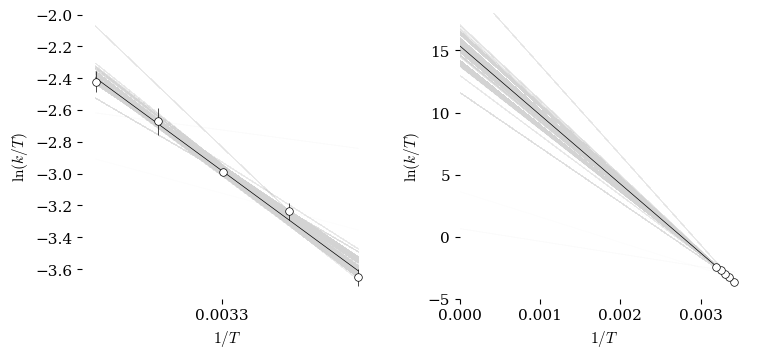

In [11]:
#######################################
### Create plot
#######################################
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0.0030,0.00354],                  
#          ylim=[-4.5,-1.1]
       )
ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim=[0, 0.0036],                  
          ylim=[-5,18]
       )
ax[1].set_xticks([0,0.001,0.002,0.003])

ax[0].scatter(x,y, marker='o', s = 30, 
              facecolor='white', edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', s = 30, 
              facecolor='white', edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
            #   capsize=2, capthick=0.5, 
               zorder=2)

for line in bs["y_for_ci"]:
    ax[0].plot(bs["x_for_ci"], line, 
               color='lightgrey', linewidth = 0.5, alpha=.05, zorder=1)
for line in bs["y0_for_ci"]:
    ax[1].plot(bs["x0_for_ci"], line, 
               color='lightgrey', linewidth = 0.5, alpha=.05, zorder=1)

#######################################
### Plot Best Fit
#######################################

ax[0].plot(bs["x_for_ci"], linear(bs["x_for_ci"], slope_u.n, intercept_u.n), 
           color='black', linewidth = 0.5, zorder=4)
ax[1].plot(bs["x0_for_ci"], linear(bs["x0_for_ci"], slope_u.n, intercept_u.n), 
           color='black', linewidth = 0.5, zorder=4)

#######################################
### Output plot
#######################################

plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_1.pdf")
plt.show()

### Checking the Distribution

We can check the quality of our bootstrap process by plotting the values for a give parameter. Let us check the calculated $\Delta S^\ddagger$ value. We will plot the values and we observe that there are several discrete values that we bounce around between rather than a smooth random. We  will also plot the distribution sorted from lowest values to highest and compare that to a distribution generated by a Gaussian probability curve.

We can see the "steps" that are the result of repeated discrete values. The low number of points means that there are many repeats of the same resample.

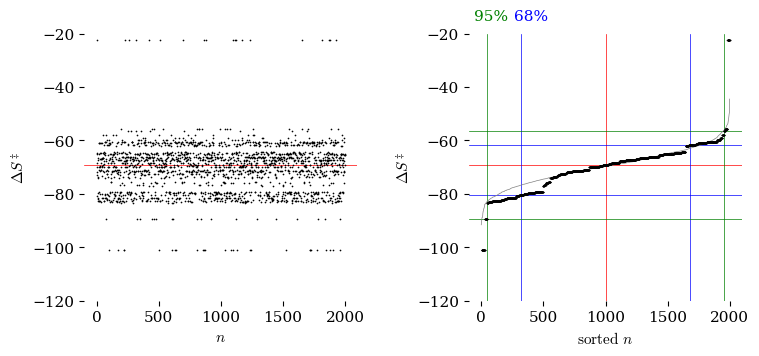

In [12]:
median = median_dS
value = dS
values = "dS_list"
ylimits = [-120,-20]

y1 = bs_simple[values].copy()
y1_sorted = sorted(y1)

x1 = np.arange(0,len(y1))


#######################################
### Create plot
#######################################
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\Delta S^*$", 
          xlabel=r"$n$",                
#          xlim=[0.0030,0.00354],                  
          ylim=ylimits
       )
#ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\Delta S^*$", 
          xlabel=r"$\rm{sorted\ }n$",                
#          xlim=[0, 0.0036],                  
          ylim=ylimits
       )
#ax[1].set_xticks([0,0.001,0.002,0.003])

ax[0].scatter(x1, y1, marker='o', s = 0.5, 
              color='black', linewidth = 0.5, zorder=1)
ax[1].scatter(x1, y1_sorted, marker='o', s = 0.5,
              color='black', linewidth = 0.5, zorder=1)


ax[0].axhline(median, color="red", linewidth = 0.5, zorder = 0)
ax[1].axhline(median, color="red", linewidth = 0.5, zorder = 0)

#################################################
### 68%
n_points = len(y1)
conf_ = sigma_dict[1]

percentile68left = np.percentile(x1,50-conf_/2)
percentile68right = np.percentile(x1,50+conf_/2)

ax[1].axvline(n_points/2, color="red", linewidth = 0.5, zorder = 0)

ax[1].axvline(percentile68left, color="blue", linewidth = 0.5, zorder = 0)
ax[1].axvline(percentile68right, color="blue", linewidth = 0.5, zorder = 0)
ax[1].text(percentile68left-50,-15,"68%", color="blue")

ax[1].axhline(np.percentile(y1,50-conf_/2), color="blue", linewidth = 0.5, zorder = 0)
ax[1].axhline(np.percentile(y1,50+conf_/2), color="blue", linewidth = 0.5, zorder = 0)

corners_x = [percentile68left, percentile68right, percentile68right, percentile68left]
corners_y = [np.percentile(y1,50-conf_/2), np.percentile(y1,50+conf_/2), 
             np.percentile(y1,50+conf_/2), np.percentile(y1,50-conf_/2)]

ax[1].fill(corners_x,corners_y,"r",zorder=9)

### 95%
conf_ = sigma_dict[2]

percentile95left = np.percentile(x1,50-conf_/2)
percentile95right = np.percentile(x1,50+conf_/2)

ax[1].axvline(percentile95left, color="green", linewidth = 0.5, zorder = 0)
ax[1].axvline(percentile95right, color="green", linewidth = 0.5, zorder = 0)
ax[1].text(percentile95left-100,-15,"95%", color="green")

ax[1].axhline(np.percentile(y1,50-conf_/2), color="green", linewidth = 0.5, zorder = 0)
ax[1].axhline(np.percentile(y1,50+conf_/2), color="green", linewidth = 0.5, zorder = 0)


#######################################
### Plot gaussin Dist (Gray line)
#######################################

y_r_list = []
for q in x1:
#   y_r = np.random.normal(dS.n, dS.s)   ### smooth with gaussian error 
    y_r = np.random.normal(value.n, value.s)   ### smooth with gaussian error 
    y_r_list.append(y_r)

y_r_list.sort()

ax[1].plot(x1, y_r_list, "-", color = "gray", linewidth = 0.5, zorder = 0)

#######################################
### Output plot
#######################################

plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_4.pdf")
plt.show()





## Smooth Bootstrap

If we do not have a large data set the bootstrap will contain many identical values and a smooth distribution of values will not be possible. However we can create more values by applying error to the data points. The below code is ifdentical to the above except that we are applying a random Gaussian distribution function to each resamples y-value. We will use the standard deviations reported for each data points to define these errors. 

Observe how the distribuition of lines is now smoother. There should be a better consistency to the percentile confidence interval values as well. 

/var/folders/3h/d_p2gtjd78g8c7m6c14chsg00000gq/T/ipykernel_43195/2731163377.py:65: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(linear, x_s, y_s)    # Curve fit the resampled data


Confidence level = 68.3%

slope range is -5164.4 to -5857.1
median slope in bootstrap population is -5555.9 + 391.5 - 301.2
best fit value for slope is -5560.1+/-249.1

intercept range is 16.34 to 14.08
median intercept in bootstrap population is 15.35 + 0.99 - 1.27
best fit value for intercept is 15.37+/-0.82

delta H range is 42939.26 to 48698.79
median delta H in bootstrap population is 46194.10 + 2504.68 - 3254.84
best fit value for delta H is 46229.03+/-2070.94

delta S range is -80.51 to -61.68
median delta S in bootstrap population is -69.95 + 8.27 - 10.56
best fit value for delta S is -69.80+/-6.84



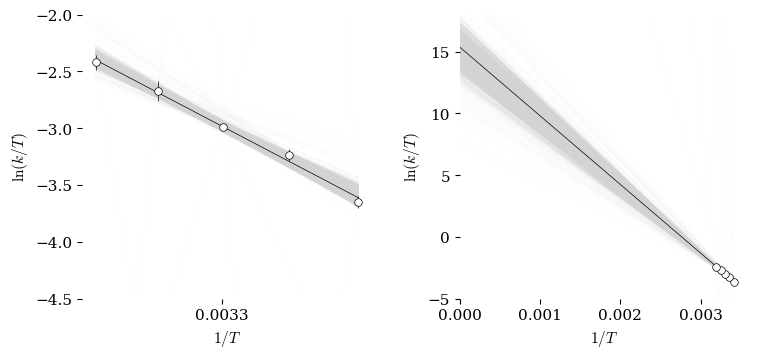

In [13]:
################################################################################
### SMOOTH BOOTSTRAP 
### 
### Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction
################################################################################

#######################################
## Global variables
#######################################

sigma = 1                 # Confidence. 1 sigma:68%, 2 sigma:95%, 3 sigma:99$
boot_n = 2000             # Number of bootstrap resamples

#######################################
## Define confidence percentile limits
#######################################

sigma_dict = {1:68.3, 2:95.5, 3:99.7}      

conf = sigma_dict[sigma]
low_p = 50 - conf/2
high_p = 50 + conf/2

#######################################
## Set up functions for curve fit and thermodynamic calculations
#######################################

def linear(x, slope, intercept):     # Linear function for line fitting
    return slope * x + intercept

def eyring_calc(slope, intercept):   # Calculate thermodynamic parameters
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1
    
    dH = -slope * R
    dS = (intercept - unp.log(kb/h)) * R
    return dH, dS

#######################################
## Bootstrap - Calculate a list of line fits for resampled data sets.
#######################################

slope_list = []               # A list of slopes from each iteration of bootstrap
intercept_list = []           # A list of intercepts

dS_list = []
dH_list = []

x_for_ci = np.linspace(np.min(x), np.max(x), 100)   # Array of x values 
x0_for_ci = np.linspace(0, np.max(x), 100)          # Array of x values starting at zero

y_list = []                   # A list of predicted values at each data point
y_for_ci = []                 # A list of sets of predicted values at each x point                     
y0_for_ci = []                # A list of sets of predicted values at each x0 point

for i in range(0, boot_n):
    pick = np.random.choice(range(0, len(y)), len(y))     # Random list of data points to pick

    x_s = x[pick]             # Get x and y values from random pick
    y_s = np.random.normal(y[pick], y_err[pick])   ### smooth with gaussian error 
    y_err_s = y_err[pick]

    popt,pcov = curve_fit(linear, x_s, y_s)    # Curve fit the resampled data

    [slope, intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    dH, dS = eyring_calc(slope, intercept)
    dH_list.append(dH)
    dS_list.append(dS)

    y_list.append(linear(x, *popt))            # Predict y at data points and add to list
    y_for_ci.append(linear(x_for_ci, *popt))   # Predict y along data range and add to list
    y0_for_ci.append(linear(x0_for_ci, *popt)) # Predict y from zero to data range and add to list

# Convert these lists of arrays to arrays of arrays (a matrix)
y_list = np.array(y_list)
y_for_ci = np.array(y_for_ci)    
y0_for_ci = np.array(y0_for_ci)

### Package up data into a dictionary object (for convenience)

bs = {
    "y_list": y_list,
    "x_for_ci": x_for_ci,
    "y_for_ci": y_for_ci,
    "x0_for_ci": x0_for_ci,
    "y0_for_ci": y0_for_ci,
    "slope_list": slope_list,
    "intercept_list": intercept_list,
    "dH_list": dH_list,
    "dS_list": dS_list
}


#######################################
## Traditional Curve Fit for Comparison
#######################################

popt,pcov = curve_fit(linear, x, y,                        # Final curve fit of original data
           #           sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

# Create new ufloat objects from returned parameters and covariance matrix results
[slope_u, intercept_u] = un.correlated_values(popt, pcov)

#######################################
### Report
#######################################
print(f"Confidence level = {conf}%")
print()

numbers = unp.nominal_values(bs["slope_list"])
top_slope = np.percentile(numbers, high_p)
bot_slope = np.percentile(numbers, low_p)
median_slope = np.median(numbers)

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope_u:0.1f}")
print()

numbers = unp.nominal_values(bs["intercept_list"])
top_intercept = np.percentile(numbers, high_p)
bot_intercept = np.percentile(numbers, low_p)
median_intercept = np.median(numbers)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept_u:0.2f}")
print()

dH, dS = eyring_calc(slope_u, intercept_u)

numbers = unp.nominal_values(bs["dH_list"])
top_dH = np.percentile(numbers, high_p)
bot_dH = np.percentile(numbers, low_p)
median_dH = np.median(numbers)

print(f"delta H range is {bot_dH:0.2f} to {top_dH:0.2f}")
print(f"median delta H in bootstrap population is {median_dH:0.2f} + {top_dH-median_dH:0.2f} - {median_dH-bot_dH:0.2f}")
print(f"best fit value for delta H is {dH:0.2f}")
print()

numbers = unp.nominal_values(bs["dS_list"])
top_dS = np.percentile(numbers, high_p)
bot_dS = np.percentile(numbers, low_p)
median_dS = np.median(numbers)

print(f"delta S range is {bot_dS:0.2f} to {top_dS:0.2f}")
print(f"median delta S in bootstrap population is {median_dS:0.2f} + {top_dS-median_dS:0.2f} - {median_dS-bot_dS:0.2f}")
print(f"best fit value for delta S is {dS:0.2f}")
print()

bs_smooth = bs.copy()

#######################################
### Create plot
#######################################
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0.0030,0.00354],                  
          ylim=[-4.5,-2]
       )
ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim=[0, 0.0036],                  
          ylim=[-5,18]
       )
ax[1].set_xticks([0,0.001,0.002,0.003])

ax[0].scatter(x,y, marker='o', s = 30, 
              color='white', edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', s = 30, 
              color='white', edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
            #   capsize=2, capthick=0.5, 
               zorder=2)

for line in y_for_ci:
    ax[0].plot(x_for_ci, line, 
               color='lightgrey', linewidth = 0.5, alpha=.05, zorder=1)
for line in y0_for_ci:
    ax[1].plot(x0_for_ci, line, 
               color='lightgrey', linewidth = 0.5, alpha=.05, zorder=1)

#######################################
### Plot Best Fit
#######################################

ax[0].plot(x_for_ci, linear(x_for_ci, slope_u.n, intercept_u.n), 
           color='black', linewidth = 0.5, zorder=4)
ax[1].plot(x0_for_ci, linear(x0_for_ci, slope_u.n, intercept_u.n), 
           color='black', linewidth = 0.5, zorder=4)


#######################################
### Output plot
#######################################
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_2.pdf")
plt.show()




### Checking the Smoothness

How is our distribution of results? Does it approach a random normal distribution? Let us see.

We observe that the distribution is more evenly spread (smoother) and the values follow a curve that resemble a gaussian distribution.

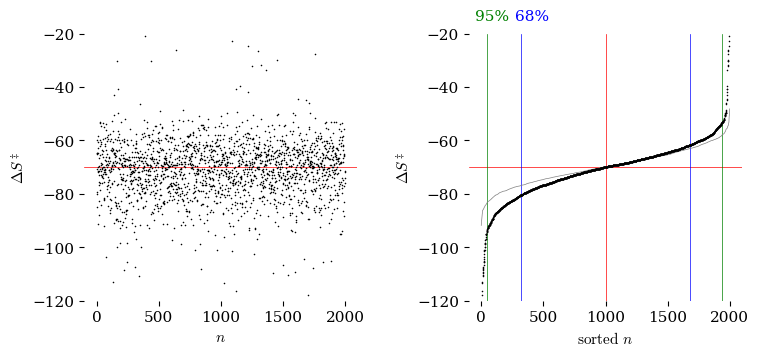

In [14]:
median = median_dS
value = dS
values = "dS_list"
ylimits = [-120,-20]

y1 = bs_smooth[values].copy()
y1_sorted = sorted(y1)

x1 = np.arange(0,len(y1))


#######################################
### Create plot
#######################################
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\Delta S^*$", 
          xlabel=r"$n$",                
#          xlim=[0.0030,0.00354],                  
          ylim=ylimits
       )
#ax[0].set_xticks([0.0031,0.0033,0.0035])

ax[1].set(
#          title = Title,       
          ylabel=r"$\Delta S^*$", 
          xlabel=r"$\rm{sorted\ }n$",                
#          xlim=[0, 0.0036],                  
          ylim=ylimits
       )
#ax[1].set_xticks([0,0.001,0.002,0.003])

ax[0].scatter(x1, y1, marker='o', s = 0.4, 
              color='black', linewidth = 0.5, zorder=1)
ax[1].scatter(x1, y1_sorted, marker='o', s = 0.4,
              color='black', linewidth = 0.5, zorder=1)


ax[0].axhline(median, color="red", linewidth = 0.5, zorder = 0)
ax[1].axhline(median, color="red", linewidth = 0.5, zorder = 0)

n_points = len(y1)
### 68%
percentile68left = np.percentile(x1,16)
percentile68right = np.percentile(x1,84)

ax[1].axvline(n_points/2, color="red", linewidth = 0.5, zorder = 0)

ax[1].axvline(percentile68left, color="blue", linewidth = 0.5, zorder = 0)
ax[1].axvline(percentile68right, color="blue", linewidth = 0.5, zorder = 0)
ax[1].text(percentile68left-50,-15,"68%", color="blue")



### 95%
percentile95left = np.percentile(x1,2.5)
percentile95right = np.percentile(x1,97.1)

ax[1].axvline(percentile95left, color="green", linewidth = 0.5, zorder = 0)
ax[1].axvline(percentile95right, color="green", linewidth = 0.5, zorder = 0)
ax[1].text(percentile95left-100,-15,"95%", color="green")


#######################################
### Plot gaussin Dist
#######################################

y_r_list = []
for q in x1:
    y_r = np.random.normal(value.n, value.s)   ### smooth with gaussian error 
    y_r_list.append(y_r)

y_r_list.sort()

ax[1].plot(x1, y_r_list, "-", color = "gray", linewidth = 0.5, zorder = 0)

#######################################
### Output plot
#######################################

plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_5.pdf")
plt.show()





## Plotting a Confidence Band

We have a set of thousands of lines plotted using the slope and intercept from the resampled and smoothed (by Gaussian error) data set. We have determined the confidence interval for the fit parameters and calculated thermodynamic paraters. Now lets plot the region of the plot that contains a band that encompasses the confidence interval for predicted y-values. All we need to do is get the percentile limits for the upper and lower confidence interval at every point that the prediction was calculated and then plot this is a filled area.

Consider the code below for plotting this band.

/var/folders/3h/d_p2gtjd78g8c7m6c14chsg00000gq/T/ipykernel_43195/3313734404.py:65: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(linear, x_s, y_s)    # Curve fit the resampled data


Confidence level = 95.5%

slope range is -4734.2 to -6249.0
median slope in bootstrap population is -5550.2 + 816.0 - 698.9
best fit value for slope is -5545.9+/-277.8

intercept range is 17.67 to 12.66
median intercept in bootstrap population is 15.34 + 2.33 - 2.68
best fit value for intercept is 15.31+/-0.92

delta H range is 39362.27 to 51957.22
median delta H in bootstrap population is 46146.60 + 5810.63 - 6784.32
best fit value for delta H is 46110.87+/-2309.56

delta S range is -92.33 to -50.66
median delta S in bootstrap population is -70.04 + 19.38 - 22.28
best fit value for delta S is -70.24+/-7.63



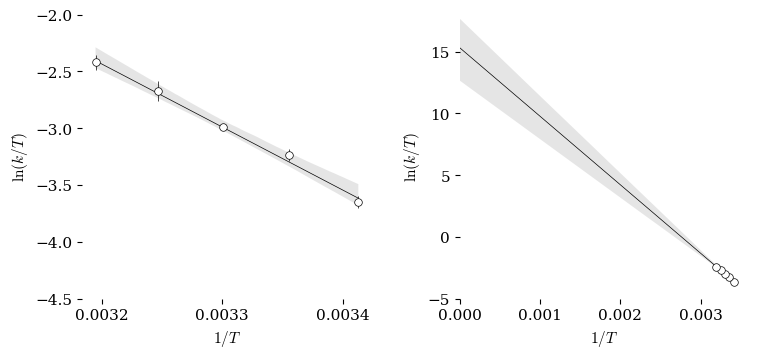

In [15]:
################################################################################
### SMOOTH BOOTSTRAP 
### 
### Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction
################################################################################

#######################################
## Global variables
#######################################

sigma = 2                 # Confidence. 1 sigma:68%, 2 sigma:95%, 3 sigma:99$
boot_n = 2000             # Number of bootstrap resamples

#######################################
## Define confidence percentile limits
#######################################

sigma_dict = {1:68.3, 2:95.5, 3:99.7}      

conf = sigma_dict[sigma]
low_p = 50 - conf/2
high_p = 50 + conf/2

#######################################
## Set up functions for curve fit and thermodynamic calculations
#######################################

def linear(x, slope, intercept):     # Linear function for line fitting
    return slope * x + intercept

def eyring_calc(slope, intercept):   # Calculate thermodynamic parameters
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1
    
    dH = -slope * R
    dS = (intercept - unp.log(kb/h)) * R
    return dH, dS

#######################################
## Bootstrap - Calculate a list of line fits for resampled data sets.
#######################################

slope_list = []               # A list of slopes from each iteration of bootstrap
intercept_list = []           # A list of intercepts

dS_list = []
dH_list = []

x_for_ci = np.linspace(np.min(x), np.max(x), 100)   # Array of x values 
x0_for_ci = np.linspace(0, np.max(x), 100)          # Array of x values starting at zero

y_list = []                   # A list of predicted values at each data point
y_for_ci = []                 # A list of sets of predicted values at each x point                     
y0_for_ci = []                # A list of sets of predicted values at each x0 point

for i in range(0, boot_n):
    pick = np.random.choice(range(0, len(y)), len(y))     # Random list of data points to pick

    x_s = x[pick]             # Get x and y values from random pick
    y_s = np.random.normal(y[pick], y_err[pick])   ### smooth with gaussian error 
    y_err_s = y_err[pick]

    popt,pcov = curve_fit(linear, x_s, y_s)    # Curve fit the resampled data

    [slope, intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    dH, dS = eyring_calc(slope, intercept)
    dH_list.append(dH)
    dS_list.append(dS)

    y_list.append(linear(x, *popt))            # Predict y at data points and add to list
    y_for_ci.append(linear(x_for_ci, *popt))   # Predict y along data range and add to list
    y0_for_ci.append(linear(x0_for_ci, *popt)) # Predict y from zero to data range and add to list

# Convert these lists of arrays to arrays of arrays (a matrix)
y_list = np.array(y_list)
y_for_ci = np.array(y_for_ci)    
y0_for_ci = np.array(y0_for_ci)

### Package up data into a dictionary object (for convenience)

bs = {
    "y_list": y_list,
    "x_for_ci": x_for_ci,
    "y_for_ci": y_for_ci,
    "x0_for_ci": x0_for_ci,
    "y0_for_ci": y0_for_ci,
    "slope_list": slope_list,
    "intercept_list": intercept_list,
    "dH_list": dH_list,
    "dS_list": dS_list
}

#######################################
## Traditional Curve Fit for Comparison
#######################################

popt,pcov = curve_fit(linear, x, y,                        # Final curve fit of original data
                      sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

# Create new ufloat objects from returned parameters and covariance matrix results
[slope_u, intercept_u] = un.correlated_values(popt, pcov)

#######################################
### Report
#######################################
print(f"Confidence level = {conf}%")
print()

numbers = unp.nominal_values(bs["slope_list"])
top_slope = np.percentile(numbers, high_p)
bot_slope = np.percentile(numbers, low_p)
median_slope = np.median(numbers)

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope_u:0.1f}")
print()

numbers = unp.nominal_values(bs["intercept_list"])
top_intercept = np.percentile(numbers, high_p)
bot_intercept = np.percentile(numbers, low_p)
median_intercept = np.median(numbers)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept_u:0.2f}")
print()

dH, dS = eyring_calc(slope_u, intercept_u)

numbers = unp.nominal_values(bs["dH_list"])
top_dH = np.percentile(numbers, high_p)
bot_dH = np.percentile(numbers, low_p)
median_dH = np.median(numbers)

print(f"delta H range is {bot_dH:0.2f} to {top_dH:0.2f}")
print(f"median delta H in bootstrap population is {median_dH:0.2f} + {top_dH-median_dH:0.2f} - {median_dH-bot_dH:0.2f}")
print(f"best fit value for delta H is {dH:0.2f}")
print()

numbers = unp.nominal_values(bs["dS_list"])
top_dS = np.percentile(numbers, high_p)
bot_dS = np.percentile(numbers, low_p)
median_dS = np.median(numbers)

print(f"delta S range is {bot_dS:0.2f} to {top_dS:0.2f}")
print(f"median delta S in bootstrap population is {median_dS:0.2f} + {top_dS-median_dS:0.2f} - {median_dS-bot_dS:0.2f}")
print(f"best fit value for delta S is {dS:0.2f}")
print()


#######################################
### Create plot
#######################################
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0.0030,0.00354],                  
          ylim=[-4.5,-2]
       )
ax[0].set_xticks([0.0032,0.0033,0.0034])

ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
          xlim=[0, 0.0036],                  
          ylim=[-5,18]
       )
ax[1].set_xticks([0,0.001,0.002,0.003])

ax[0].scatter(x,y, marker='o', s = 30, 
              color='white', edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', s = 30, 
              color='white', edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=2*y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
            #   capsize=2, capthick=0.5, 
               zorder=2)

#######################################
### Plot Best Fit
#######################################

ax[0].plot(x_for_ci, linear(x_for_ci, slope_u.n, intercept_u.n), 
           color='black', linewidth = 0.5, zorder=4)
ax[1].plot(x0_for_ci, linear(x0_for_ci, slope_u.n, intercept_u.n), 
           color='black', linewidth = 0.5, zorder=4)


#######################################
### Interval
#######################################
top_y = []
bot_y = []
med_y = []

for n in range(len(x_for_ci)):
    top_y.append(np.percentile(y_for_ci[:,n], high_p))
    bot_y.append(np.percentile(y_for_ci[:,n], low_p))
    med_y.append(np.percentile(y_for_ci[:,n], 50))

ax[0].fill_between(x_for_ci, top_y, bot_y, 
                   facecolor="gray", alpha=0.2, zorder = 0,
                   label="confidence interval")

#######################################
### Interval
#######################################
top_y = []
bot_y = []
med_y = []

for n in range(len(x0_for_ci)):
    top_y.append(np.percentile(y0_for_ci[:,n], high_p))
    bot_y.append(np.percentile(y0_for_ci[:,n], low_p))
    med_y.append(np.percentile(y0_for_ci[:,n], 50))

ax[1].fill_between(x0_for_ci, top_y, bot_y, 
                   facecolor="gray", alpha=0.2, zorder = 0,
                   label="confidence interval")
 

#######################################
### Output plot
#######################################
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/Eyring_bootstrap_6.pdf")
plt.show()




## Bonus: Gaussian Error

The smooth bootstrap above used a function that applied Guassian error to our data point. We can visualize the distrubution of Guassian error using a "normal distribution" function. Consider the code below.

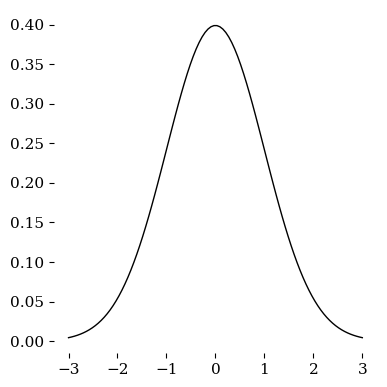

In [16]:
x_data = np.linspace(-3,3,100)
y_data = scipy.stats.norm.pdf(x_data, 0, 1)
plt.plot(x_data, y_data)

## Bonus: Bootstrap Step by Step

below is code that makes a plot of twelve example boostrap runs. In each a different set of the five data points, randomly chose with replacement, is presented. Imagine that this was the first twelve plots in the 2000 we ran for each bootstrap above.

In [17]:
#######################################
## Set up functions for curve fit and thermodynamic calculations
#######################################

def linear(x, slope, intercept):     # Linear function for line fitting
    return slope * x + intercept

def eyring_calc(slope, intercept):   # Calculate thermodynamic parameters
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1
    
    dH = -slope * R
    dS = (intercept - unp.log(kb/h)) * R
    return dH, dS

def contact_sheet(ax, x, y, y_err = [0,] * len(y),
            samples = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15"]):
    """Plots 12 plots, one for each column of plate
    
    Will produce a 'contact sheet' of plots, one for each plat column
    
    Arguments:
    ---------
    data_root_name: string
        The file root name. Column and row labels will be added.
    columns, row: lists
        These are the lists of names for the columns and rows. Will be appended
        to data_root_name to access the individual data files.
    enzymes: list
        The names of the enzymes (or other note) in each column.
        Will be printed on each plot for corresponding column
    Returns: 
    -------

    Nul

    Will output the 3 column X 4 row plot of all data sets in the plate
    and save the plot as a pdf file.
    """
    n = 0  ### set counter
    for plot_name in samples:
        
        pick = np.random.choice(range(0, len(y)), len(y))     # Random list of data points to pick
    
        x_s = x[pick]             # Get x and y values from random pick
        y_s = np.random.normal(y[pick], y_err[pick])   ### smooth with gaussian error 
        y_err_s = y_err[pick]
    
        popt,pcov = curve_fit(linear, x_s, y_s)    # Curve fit the resampled data
    
        [slope, intercept] = popt



        plot_row = n // 5   ### use counter to get column and row
        plot_col = n % 5
    
        ax[plot_row][plot_col].set(
                    xlabel = None, 
                    ylabel = None,
                    xlim = [.00315, .00345],                  
                    ylim = [-3.9, -2.3])
        

        ### Column 0 gets y-axis label and ticks.
        ax[plot_row][0].set(ylabel= r"$\ln{k/T}$")
#        ax[plot_row][0].set_yticks([-2.5,-3.0,-3.5])
        ### Columns 1 & 2 get no y-axis ticks.
        ax[plot_row][1].set_yticks([])
        ax[plot_row][2].set_yticks([])
        ax[plot_row][3].set_yticks([])
        ax[plot_row][4].set_yticks([])
    
        ### Row 3 (bottom) gets x-axis label and ticks.
        ax[2][plot_col].set(xlabel= r"$1/T$")
        ax[0][plot_col].set_xticks([])
        ### Other rows get no x-axis ticks.
        ax[1][plot_col].set_xticks([])
    
#        ax[plot_row][plot_col].text(.00317, -2.25, "Sample "+str(plot_name)) 

        ax[plot_row][plot_col].plot(x, linear(x, slope, intercept), 
                                    linestyle = '-', 
                                    linewidth='0.3', 
                                    color = 'black', 
                                    zorder = 0)
        ax[plot_row][plot_col].scatter(x_s, y_s, 
                                       marker='o', 
                                       color='black', 
                                       edgecolors = None,
                                       linewidths = 0.5, 
                                       s=20, 
                                       zorder = 2)
        ax[plot_row][plot_col].scatter(x_s, y_s, 
                                       marker='o', 
                                       color='white', 
                                       edgecolors = None,
                                       linewidths = 0.5, 
                                       s=10, 
                                       zorder = 1)
        ### end of for row_name in row_name_list:

        n += 1    ### increment counter
    ### end of for lane_name in lane_name_list:

    return()


plt.ioff()      ### switch off interactive display of plots. plt.show() needed to display a plot now
plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
if True:
    plt.style.use(location_styles + "tufte.mplstyle")


for a in range(10):                  ### Make ten sets of bootstrap examples
    fig, ax = plt.subplots(nrows=3, 
                           ncols=5, 
                           figsize=(15,9), 
                        #   sharex=True, 
                        #   sharey=True
                           )  
    
    temp = [293, 298, 303, 308, 313]       # list of temperatures
    k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
    k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data
    
    ### Convert lists to numpy arrays (enables numpy math tools with these lists)
    temp = np.array(temp)
    k_obs = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values
    
    ### Calculations for Erying plot axes
    x = 1/temp
    y_u = unp.log(k_obs/temp)   # y_u is now an array of ufloats
    
    y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
    y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats
    
    contact_sheet(ax, x, y, y_err)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig("plots/plot_contact_sheet"+str(a)+".pdf")     ### export the plot as this
    #plt.show()                 ### display the plot in this notebook
    print("Plot saved as plots/plot_contact_sheet.pdf")
    plt.close()


Plot saved as plots/plot_contact_sheet.pdf
Plot saved as plots/plot_contact_sheet.pdf
Plot saved as plots/plot_contact_sheet.pdf
Plot saved as plots/plot_contact_sheet.pdf
Plot saved as plots/plot_contact_sheet.pdf
Plot saved as plots/plot_contact_sheet.pdf
Plot saved as plots/plot_contact_sheet.pdf
Plot saved as plots/plot_contact_sheet.pdf
Plot saved as plots/plot_contact_sheet.pdf
Plot saved as plots/plot_contact_sheet.pdf
